In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannot import add_stat_annotation
import squidpy as sq
import grafiti as gf

import warnings
warnings.filterwarnings('ignore')

datadir = '/data1/shahs3/users/mezallj1/data/dlpfc'
figdir = '/data1/shahs3/users/mezallj1/figures/dlpfc'

In [2]:
def read_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
def plot_spatial(datadir, slice, figsize, save=None):
    adata_graphst = sc.read_h5ad(f'{datadir}/graphst/{slice}_graphst_seeded.h5ad')
    adata_stagate = sc.read_h5ad(f'{datadir}/stagate/{slice}_stagate_seeded.h5ad')
    adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{slice}_grafiti_lodcl_50_50_0.0001_1_10_1.h5ad')
    adata_og_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{slice}_grafiti.h5ad')

    adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')
    
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color='Region', shape=None, ax=axes[0], size=100, dpi=300, save=f'{save}_gt.pdf')
    sq.pl.spatial_scatter(adata_graphst, title = 'GraphST: %.3f'%(graphst[slice]), color ='mclust', shape=None, ax=axes[1], size=100, dpi=300,save=f'{save}_graphst.pdf')
    sq.pl.spatial_scatter(adata_stagate, title = 'STAGATE: %.3f'%(stagate[slice]), color ='mclust', shape=None, ax=axes[2], size=100, dpi=300,save=f'{save}_stagate.pdf')
    sq.pl.spatial_scatter(adata_grafiti, title = 'GRAFITICL: %.3f'%(grafiti[slice]), color ='grafiti_motif', shape=None, ax=axes[3], size=100, dpi=300,save=f'{save}_grafiti.pdf')
    sq.pl.spatial_scatter(adata_og_grafiti, title = 'GRAFITI: %.3f'%(og_grafiti[slice]), color ='grafiti_motif', shape=None, ax=axes[4], size=100, dpi=300,save=f'{save}_og_grafiti.pdf')
    plt.tight_layout()
    #if save != None:
    #    fig.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def plot_boxplot(list_dic, categories,title,figsize,save):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)
    
    # Plotting
    plt.figure(figsize=(12, 16))
    sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
    sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)
    
    # Customizing the plot
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Augmentation Modality')
    plt.title(title)
    plt.tight_layout()
    if save != None:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()
    plt.show()

In [5]:
def plot_violinplot(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Score', y='Method', data=df_melted, palette='Set2')
    sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)
    
    # Customizing the plot
    plt.xlabel('Adjusted Rand Index (ARI)')
    plt.ylabel('Method')
    plt.title('DLPFC (12 Slices)')
    plt.show()

In [6]:
def pairwise_comparison(list_dic, categories):
    df = pd.DataFrame({categories[0]:list_dic[0]})
    
    if len(list_dic) != len(categories):
        raise ValueError('The sie of both inputs should be the same')
        
    for i in range(1,len(list_dic)):
        df[categories[i]] = df.index.to_series().map(list_dic[i])

    # Transpose the DataFrame to get keys as rows and dictionaries as columns
    df = df.T
    
    # Melt the DataFrame for seaborn
    df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
    df_melted.rename(columns={'index': 'Method'}, inplace=True)

    # Perform Tukey's HSD test for pairwise comparison
    tukey_result = pairwise_tukeyhsd(endog=df_melted['Score'], groups=df_melted['Method'], alpha=0.05)
    print(tukey_result)

In [7]:
def create_comparison_plot(list_dic, categories, indices, type, title, figsize, save=None):
    # Ensure inputs are of the same length
    if len(list_dic) != len(categories):
        raise ValueError('The size of both inputs should be the same')

    # Select only the specified indices
    list_dic = [list_dic[i] for i in indices]
    categories = [categories[i] for i in indices]

    # Create DataFrame from the first dictionary
    df = pd.DataFrame(list_dic[0].items(), columns=['Index', categories[0]])
    
    # Add subsequent dictionaries to the DataFrame
    for i in range(1, len(list_dic)):
        df = df.merge(pd.DataFrame(list_dic[i].items(), columns=['Index', categories[i]]), on='Index', how='outer')

    # Melt the DataFrame for seaborn
    df_melted = df.melt(id_vars='Index', var_name='Method', value_name='Score')

    # Extract unique methods for creating pairs
    unique_methods = df_melted['Method'].unique()

    # Create pairs only for methods present in the melted DataFrame
    pairs = [(unique_methods[i], unique_methods[j]) for i in range(len(unique_methods)) for j in range(i + 1, len(unique_methods))]

    # Create the plot
    plt.figure(figsize=figsize)
    if type == 'boxplot':
        ax = sns.boxplot(x='Method', y='Score', data=df_melted, palette='Set2', fliersize=0)
    elif type == 'violinplot':
        ax = sns.violinplot(x='Method', y='Score', data=df_melted, palette='Set2', fliersize=0)
    ax = sns.swarmplot(x='Method', y='Score', data=df_melted, color='.25', size=5)

    # Rotate y-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add statistical annotations using statannot
    add_stat_annotation(ax, data=df_melted, x='Method', y='Score',
                        box_pairs=pairs,
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2, comparisons_correction='bonferroni', 
                        line_height=0.02, linewidth=1.5, fontsize='medium')

    plt.xlabel('Method', fontsize=14)
    plt.ylabel('Adjusted Rand Index (ARI)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    if save != None:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
stagate = read_pickle(f'{datadir}/stagate/ari_stagate_seeded.pkl')
graphst = read_pickle(f'{datadir}/graphst/ari_graphst_seeded.pkl')
grafiti = read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_1_10_1.h5ad')
og_grafiti = read_pickle(f'{datadir}/grafiti/ari_grafiti.pkl')

In [9]:
stagate

{'151673': 0.33293315563910625,
 '151510': 0.3572377194699102,
 '151672': 0.4342564978829444,
 '151669': 0.28814774187526976,
 '151674': 0.3519531633530422,
 '151671': 0.29464444886658075,
 '151676': 0.30645131563470107,
 '151508': 0.3110608284992572,
 '151670': 0.224196169576054,
 '151509': 0.4350215641575303,
 '151507': 0.3742268910701633,
 '151675': 0.3664831496700788}

In [10]:
graphst

{'151673': 0.5998853128696566,
 '151510': 0.4867341042731746,
 '151672': 0.4660883841743893,
 '151669': 0.3866047103332981,
 '151674': 0.44224595228963287,
 '151671': 0.5760126815466183,
 '151676': 0.5373622642794826,
 '151508': 0.44886510035018906,
 '151670': 0.3603030459168644,
 '151509': 0.40500383502280424,
 '151507': 0.428203561470316,
 '151675': 0.48444512210933055}

In [11]:
grafiti

{'151673': 0.4780757372242282,
 '151510': 0.4692918537983189,
 '151672': 0.7219976520077364,
 '151669': 0.2597426888983277,
 '151674': 0.28993191412951275,
 '151671': 0.48498257520434196,
 '151676': 0.36619031321095796,
 '151508': 0.4168268332172062,
 '151670': 0.2824612831002625,
 '151509': 0.3769727779243793,
 '151507': 0.6580068236066369,
 '151675': 0.296884189250042}

In [12]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [13]:
df = pd.DataFrame({
    'GraphST': graphst,
    'STAGATE': stagate,
    'Graffiti': grafiti
})

In [14]:
df

GraphST   STAGATE  Graffiti
151673  0.599885  0.332933  0.478076
151510  0.486734  0.357238  0.469292
151672  0.466088  0.434256  0.721998
151669  0.386605  0.288148  0.259743
151674  0.442246  0.351953  0.289932
151671  0.576013  0.294644  0.484983
151676  0.537362  0.306451  0.366190
151508  0.448865  0.311061  0.416827
151670  0.360303  0.224196  0.282461
151509  0.405004  0.435022  0.376973
151507  0.428204  0.374227  0.658007
151675  0.484445  0.366483  0.296884

In [15]:
# Transpose the DataFrame to get keys as rows and dictionaries as columns
df = df.T

# Melt the DataFrame for seaborn
df_melted = df.reset_index().melt(id_vars='index', var_name='Sample', value_name='Score')
df_melted.rename(columns={'index': 'Method'}, inplace=True)

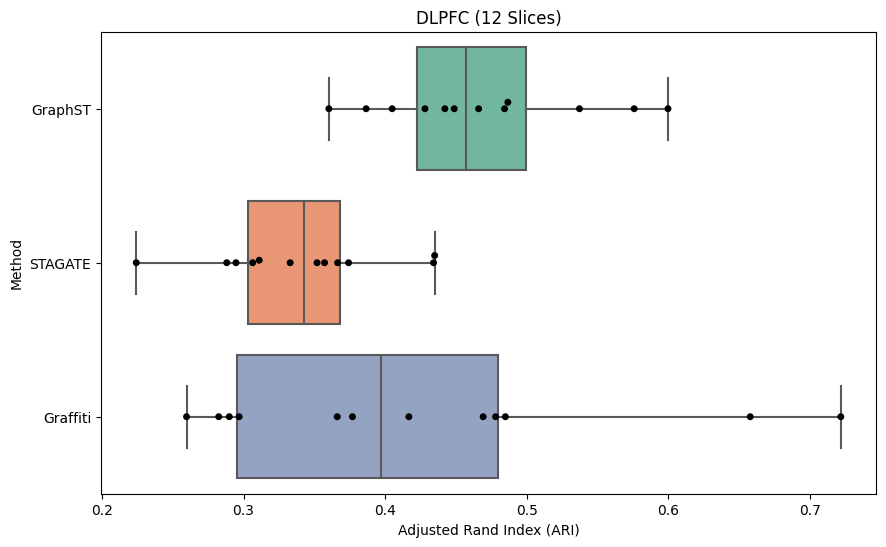

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Score', y='Method', data=df_melted, palette='Set2')
sns.swarmplot(x='Score', y='Method', data=df_melted, color='k', size=5)

# Customizing the plot
plt.xlabel('Adjusted Rand Index (ARI)')
plt.ylabel('Method')
plt.title('DLPFC (12 Slices)')
plt.show()

In [17]:
list_dic = [
    read_pickle(f'{datadir}/grafiti/ari_grafiti.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_v3.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_norm.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2_s.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2_s2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v3.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v4.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v5.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_v2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_v2_2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_v3.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_v3_2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_v4.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cu_v4_2.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_dcl_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_dcl_norm_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cudcl_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cudcl_norm_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_dcl_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_cudcl_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl2_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl2_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl2_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl2_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl2_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl2_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_1_10_1.h5ad') ,
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_nn_node_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_nn_node_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_nn_node_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_nn_node_50_50_0.0001_5_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_nn_node_50_50_0.0001_10_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_10_1_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_10_1_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_5_5_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_5_5_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_1_10_0.995.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_pca_64_0.0001_10_1_1.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_pca_64_0.0001_5_5_1.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_pca_64_0.0001_1_10_1.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_pca_64_0.0001_5_10_1.pkl'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_pca_64_0.0001_10_5_1.pkl'),
]
categories = [
    'Original',
    'Early Stopping',
    'Original with Adam Optimizer',
    'Contrastive Learning DGI',
    'Contrastive Learning DGI Normalized',
    'Contrastive Learning DGI with Adam Optimizer [5,5]',
    'Contrastive Learning DGI with Adam Optimizer [5,5] - Seeded y=1',
    'Contrastive Learning DGI with Adam Optimizer [5,5] - Seeded 2 y=.995',
    'Contrastive Learning DGI with Adam Optimizer [10,1]',
    'Contrastive Learning DGI with Adam Optimizer [1,10] - Seeded',
    'Contrastive Learning DGI with Adam Optimizer [0,1] - Seeded',
    'Contrastive Learning GraphCL with Adam Optimizer [10,10] - Seeded y=.995',
    'Contrastive Learning GraphCL with Adam Optimizer [10,10] - Seeded y=1',
    'Contrastive Learning GraphCL with Adam Optimizer [5,5] - Seeded y=.995',
    'Contrastive Learning GraphCL with Adam Optimizer [5,5] - Seeded y=1',
    'Contrastive Learning GraphCL with Adam Optimizer [1,10] - Seeded y=.995',
    'Contrastive Learning GraphCL with Adam Optimizer [1,10] - Seeded y=1',
    'Contrastive Learning GraphCL with Adam Optimizer [0,1] - Seeded y=.995',
    'Contrastive Learning GraphCL with Adam Optimizer [0,1] - Seeded y=1',
    'Contrastive Learning DGI [10,1]',
    'Contrastive Learning DGI Normalized [10,1]',
    'Contrastive Learning DGI on Reconstruction [10,1]',
    'Contrastive Learning DGI on Reconstruction Normalized [10,1]',
    'Contrastive Learning DGI [5,5]',
    'Contrastive Learning DGI on Reconstruction [5,5]',
    'Contrastive Learning DGI Local Read [10,1] - y=.995',
    'Contrastive Learning DGI Local Read [10,1] - y=1',
    'Contrastive Learning DGI Local Read [5,5] - y=.995',
    'Contrastive Learning DGI Local Read [5,5] - y=1',
    'Contrastive Learning DGI Local Read [1,10] - y=.995',
    'Contrastive Learning DGI Local Read [1,10] - y=1',
    'Contrastive Learning DGI Double Local Read [10,1] - y=.995',
    'Contrastive Learning DGI Double Local Read [10,1] - y=1',
    'Contrastive Learning DGI Double Local Read [5,5] - y=.995',
    'Contrastive Learning DGI Double Local Read [5,5] - y=1',
    'Contrastive Learning DGI Double Local Read [1,10] - y=.995',
    'Contrastive Learning DGI Double Local Read [1,10] - y=1',
    'Contrastive Learning GraphCL Local Read N&E [10,1] - y=.995',
    'Contrastive Learning GraphCL Local Read N&E [10,1] - y=1',
    'Contrastive Learning GraphCL Local Read N&E [5,5] - y=.995',
    'Contrastive Learning GraphCL Local Read N&E [5,5] - y=1',
    'Contrastive Learning GraphCL Local Read N&E [1,10] - y=.995',
    'Contrastive Learning GraphCL Local Read N&E [1,10] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Mask [10,1] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Mask [10,1] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Mask [5,5] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Mask [5,5] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Mask [1,10] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Mask [1,10] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Edge [10,1] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Edge [10,1] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Edge [5,5] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Edge [5,5] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Edge [1,10] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Edge [1,10] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Node [10,1] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Node [10,1] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Node [5,5] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Node [5,5] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Node [1,10] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Node [1,10] - y=1',
    'Contrastive Learning GraphCL Local-Global NoNorm Read Node [10,1] - y=1',
    'Contrastive Learning GraphCL Local-Global NoNorm Read Node [5,5] - y=1',
    'Contrastive Learning GraphCL Local-Global NoNorm Read Node [1,10] - y=1',
    'Contrastive Learning GraphCL Local-Global NoNorm Read Node [5,10] - y=1',
    'Contrastive Learning GraphCL Local-Global NoNorm Read Node [10,5] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Subgraph [10,1] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Subgraph [10,1] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Subgraph [5,5] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Subgraph [5,5] - y=1',
    'Contrastive Learning GraphCL Local-Global Read Subgraph [1,10] - y=.995',
    'Contrastive Learning GraphCL Local-Global Read Subgraph [1,10] - y=1',
    'Contrastive Learning DGI Local PCA Reconstruction [10,1] - y=1',
    'Contrastive Learning DGI Local PCA Reconstruction [5,5] - y=1',
    'Contrastive Learning DGI Local PCA Reconstruction [1,10] - y=1',
    'Contrastive Learning DGI Local PCA Reconstruction [5,10] - y=1',
    'Contrastive Learning DGI Local PCA Reconstruction [10,5] - y=1',
]

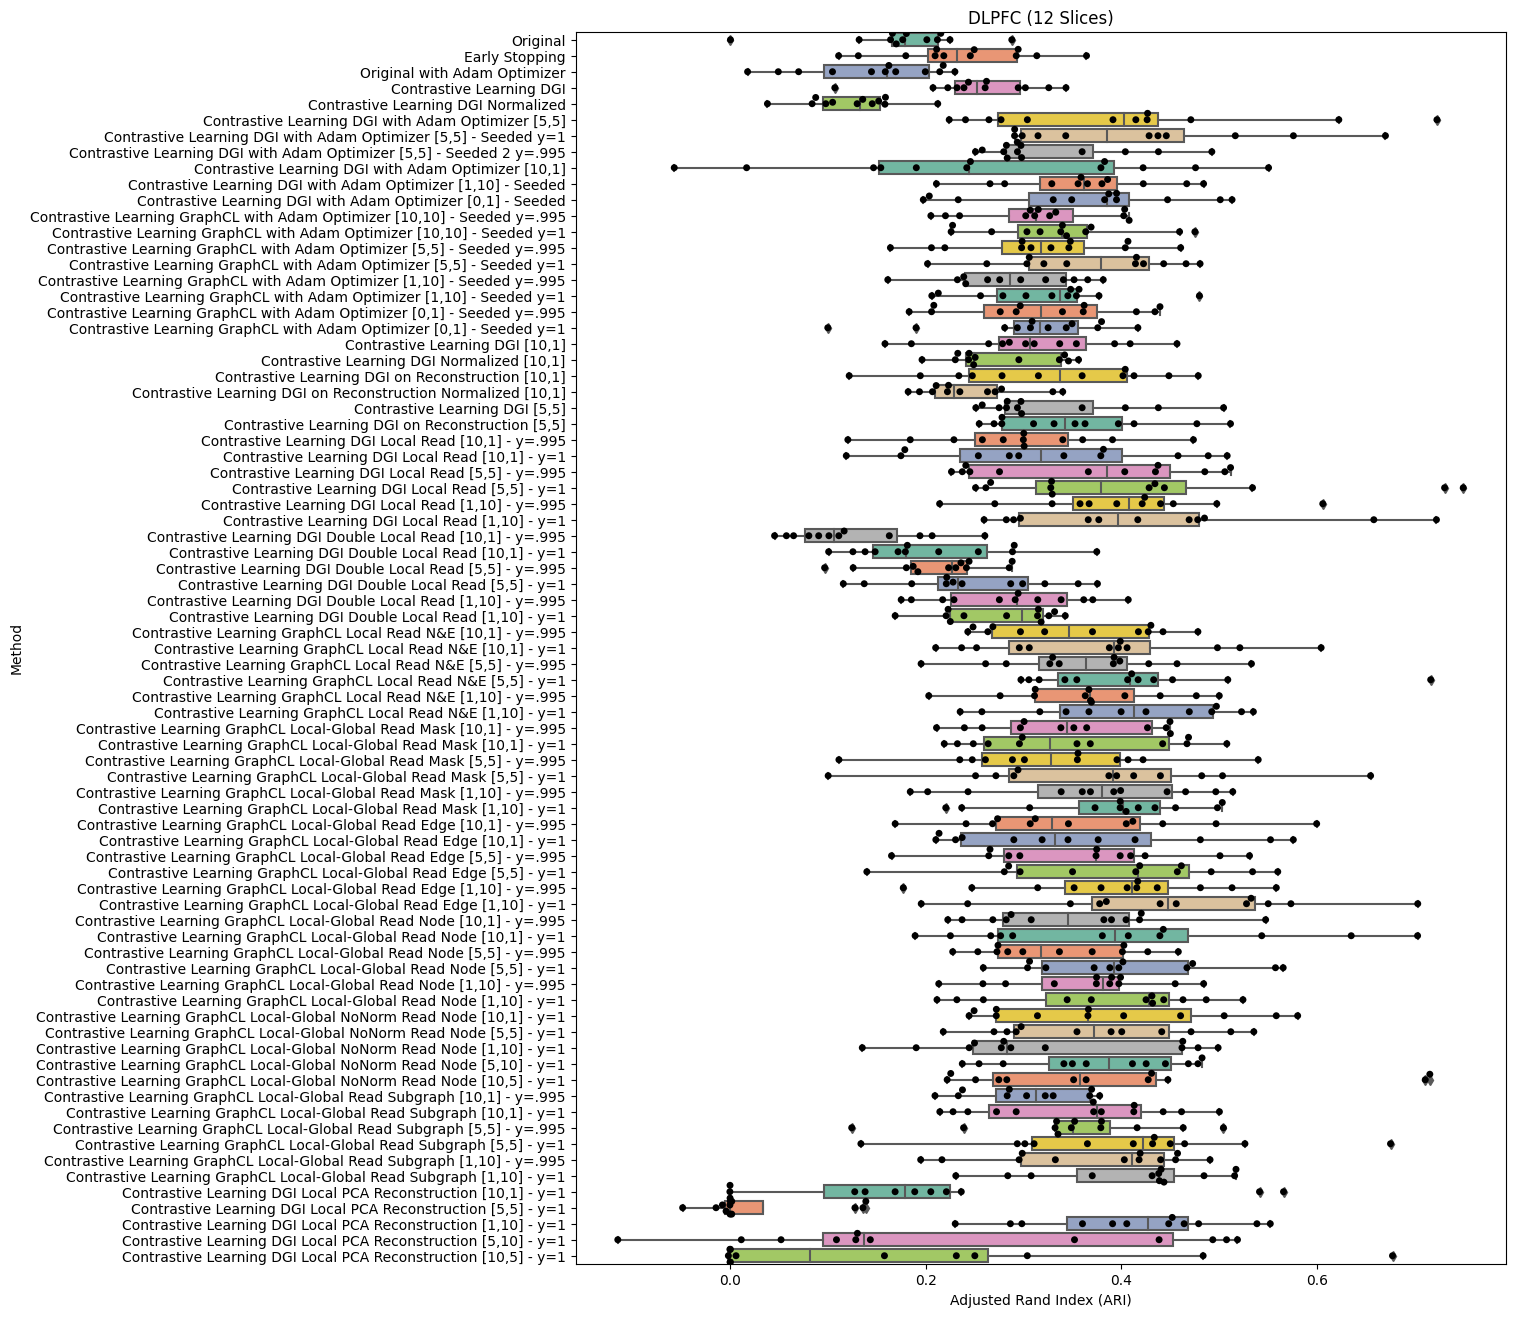

In [18]:
plot_boxplot(list_dic[:],categories[:])

In [48]:
list_dic = [
    read_pickle(f'{datadir}/grafiti/ari_grafiti_lodcl_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_node_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_edge_50_50_0.0001_1_10_1.h5ad'),
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_mask_50_50_0.0001_1_10_1.h5ad') ,
    read_pickle(f'{datadir}/grafiti/ari_grafiti_gcl_subgraph_50_50_0.0001_1_10_1.h5ad'),
]
categories = [
    'No Augmentation',
    'Node Dropping',
    'Edge Perturbation',
    'Feature Masking',
    'Subgraph Sampling',
]

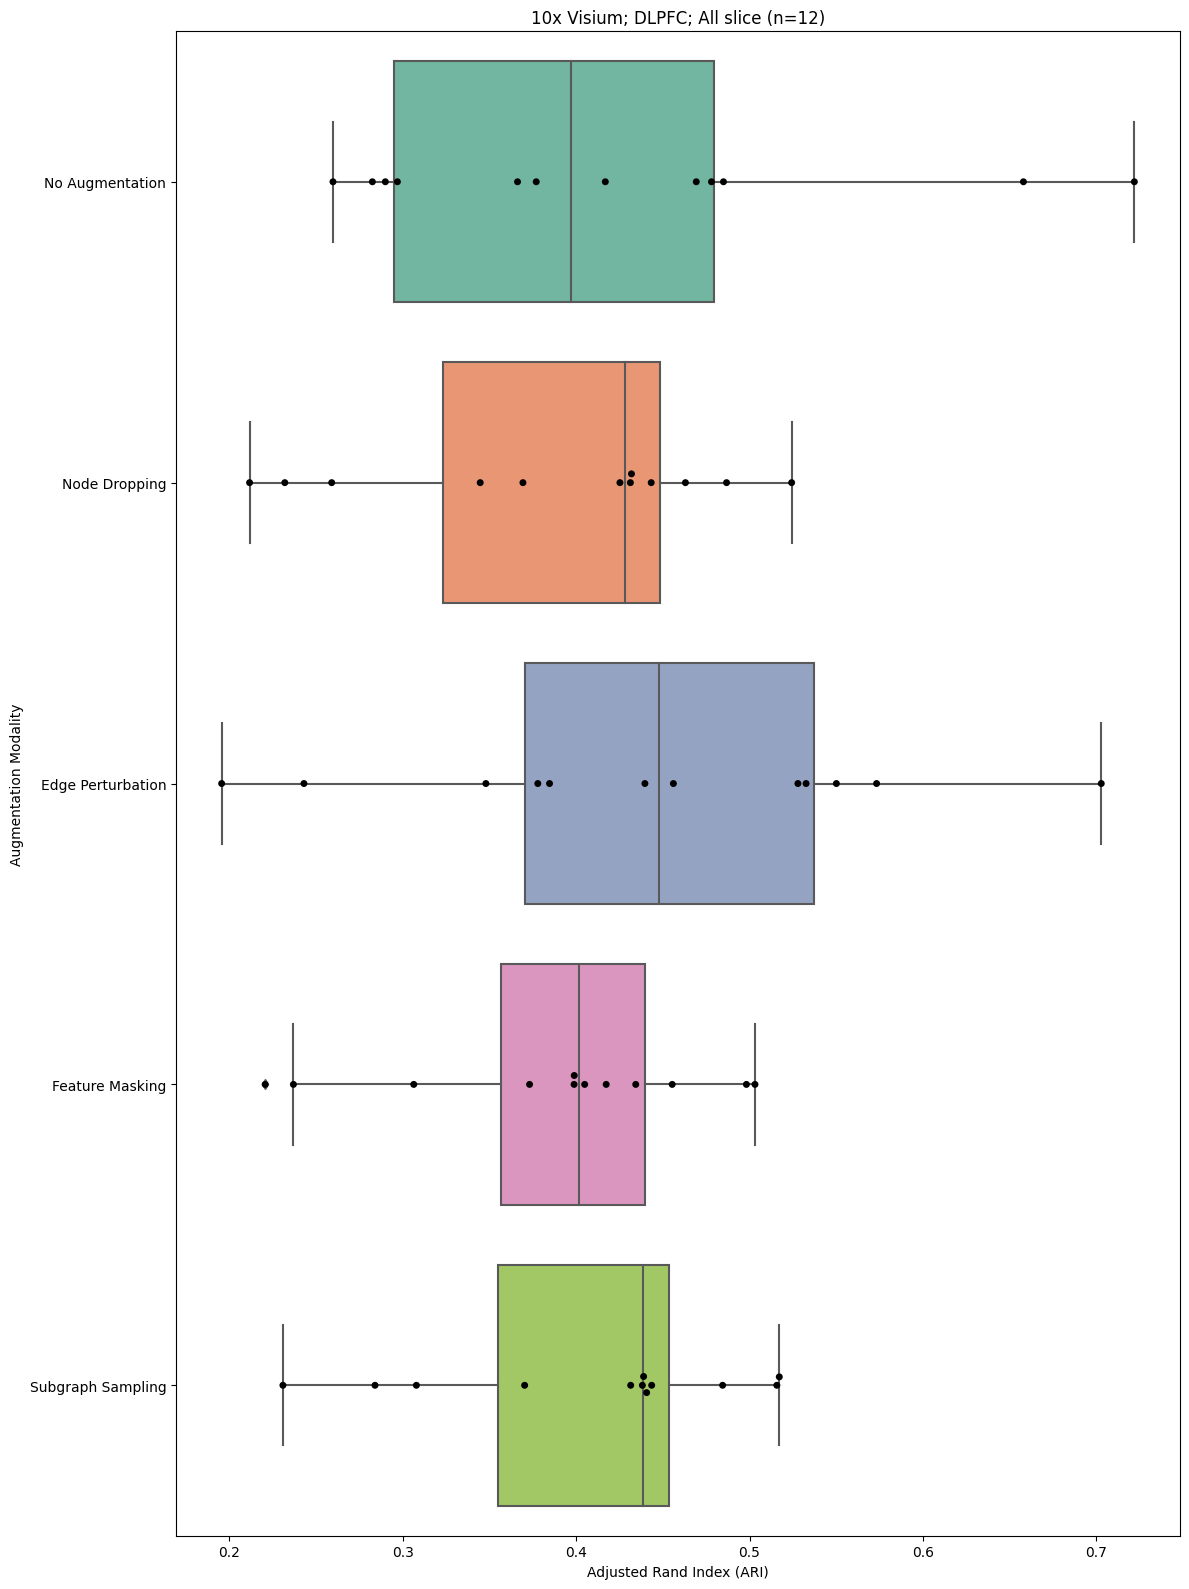

In [54]:
plot_boxplot(list_dic[:],categories[:],'10x Visium; DLPFC; All slice (n=12)',(2,2),f'{figdir}/augmentation_boxplot.pdf')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

No Augmentation v.s. Node Dropping: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+01
Node Dropping v.s. Edge Perturbation: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.100e+01
Edge Perturbation v.s. Feature Masking: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.200e+01
Feature Masking v.s. Subgraph Sampling: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.700e+01
No Augmentation v.s. Edge Perturbation: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.300e+01
Node Dropping v.s. Feature Masking: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.400e+01
Edge Perturbation 

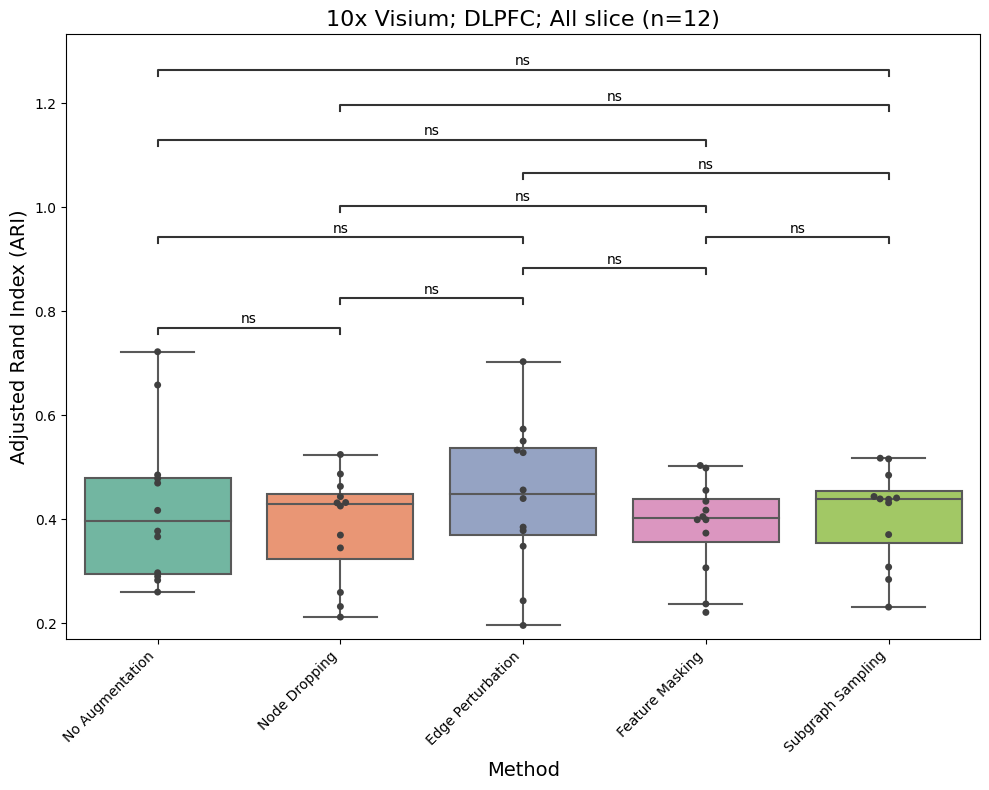

In [57]:
create_comparison_plot(list_dic, categories, [0,1,2,3,4], 'boxplot', '10x Visium; DLPFC; All slice (n=12)', figsize=(10,8), save=f'{figdir}/augmentation_boxplot.pdf')

In [19]:
#pairwise_comparison(list_dic[:5], categories[:5])
create_comparison_plot(list_dic, categories, [28,30], 'boxplot')

TypeError: create_comparison_plot() missing 1 required positional argument: 'title'

In [ ]:
create_comparison_plot(list_dic, categories, [56,58,60,61,62,63,64,65], 'boxplot')

In [ ]:
create_comparison_plot(list_dic, categories, [56,58,60,61,62,63,64,65], 'boxplot')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GRAFITI v.s. GRAFITICL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.603e-04 U_stat=2.000e+00
GRAFITICL v.s. STAGATE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.500e+01
STAGATE v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.305e-03 U_stat=1.000e+01
GRAFITI v.s. STAGATE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.603e-04 U_stat=2.000e+00
GRAFITICL v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.100e+01
GRAFITI v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.195e-04 U_stat=0.000e+00


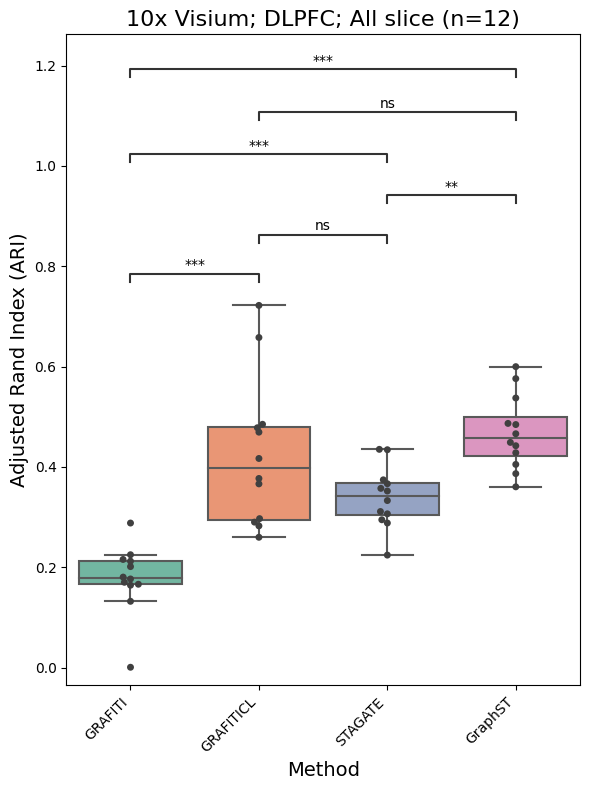

In [36]:
create_comparison_plot([og_grafiti,grafiti,stagate,graphst], ['GRAFITI','GRAFITICL','STAGATE','GraphST'], [0,1,2,3], 'boxplot', '10x Visium; DLPFC; All slice (n=12)', figsize=(6,8), save=f'{figdir}/boxplot.pdf')

In [57]:
import numpy as np
np.median(list(grafiti.values()))/np.median(list(og_grafiti.values()))

2.2237938430421753

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GRAFITI v.s. GRAFITICL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.595e-04 U_stat=3.000e+00
GRAFITICL v.s. STAGATE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.700e+01
STAGATE v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.305e-03 U_stat=1.000e+01
GRAFITI v.s. STAGATE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.603e-04 U_stat=2.000e+00
GRAFITICL v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.457e-01 U_stat=4.600e+01
GRAFITI v.s. GraphST: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.195e-04 U_stat=0.000e+00


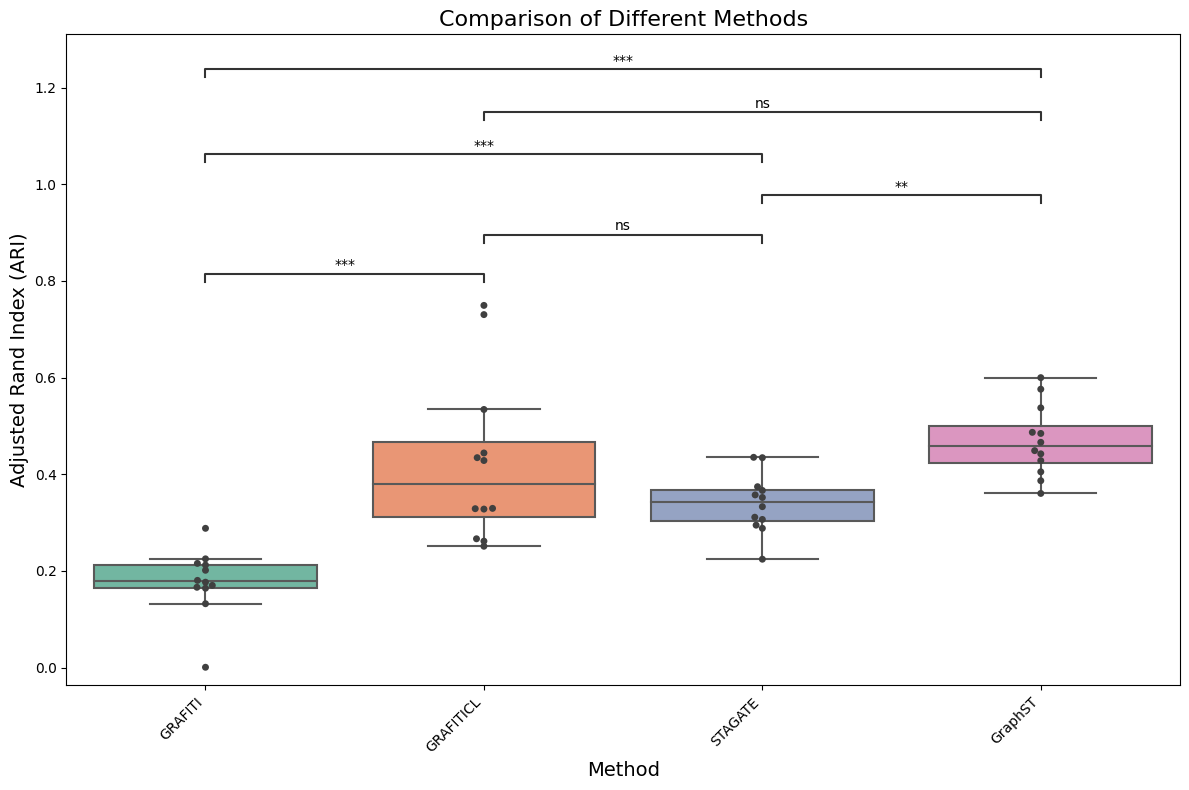

In [41]:
create_comparison_plot([og_grafiti,grafiti,stagate,graphst], ['GRAFITI','GRAFITICL','STAGATE','GraphST'], [0,1,2,3], 'boxplot')

TypeError: savefig() missing 1 required positional argument: 'fname'

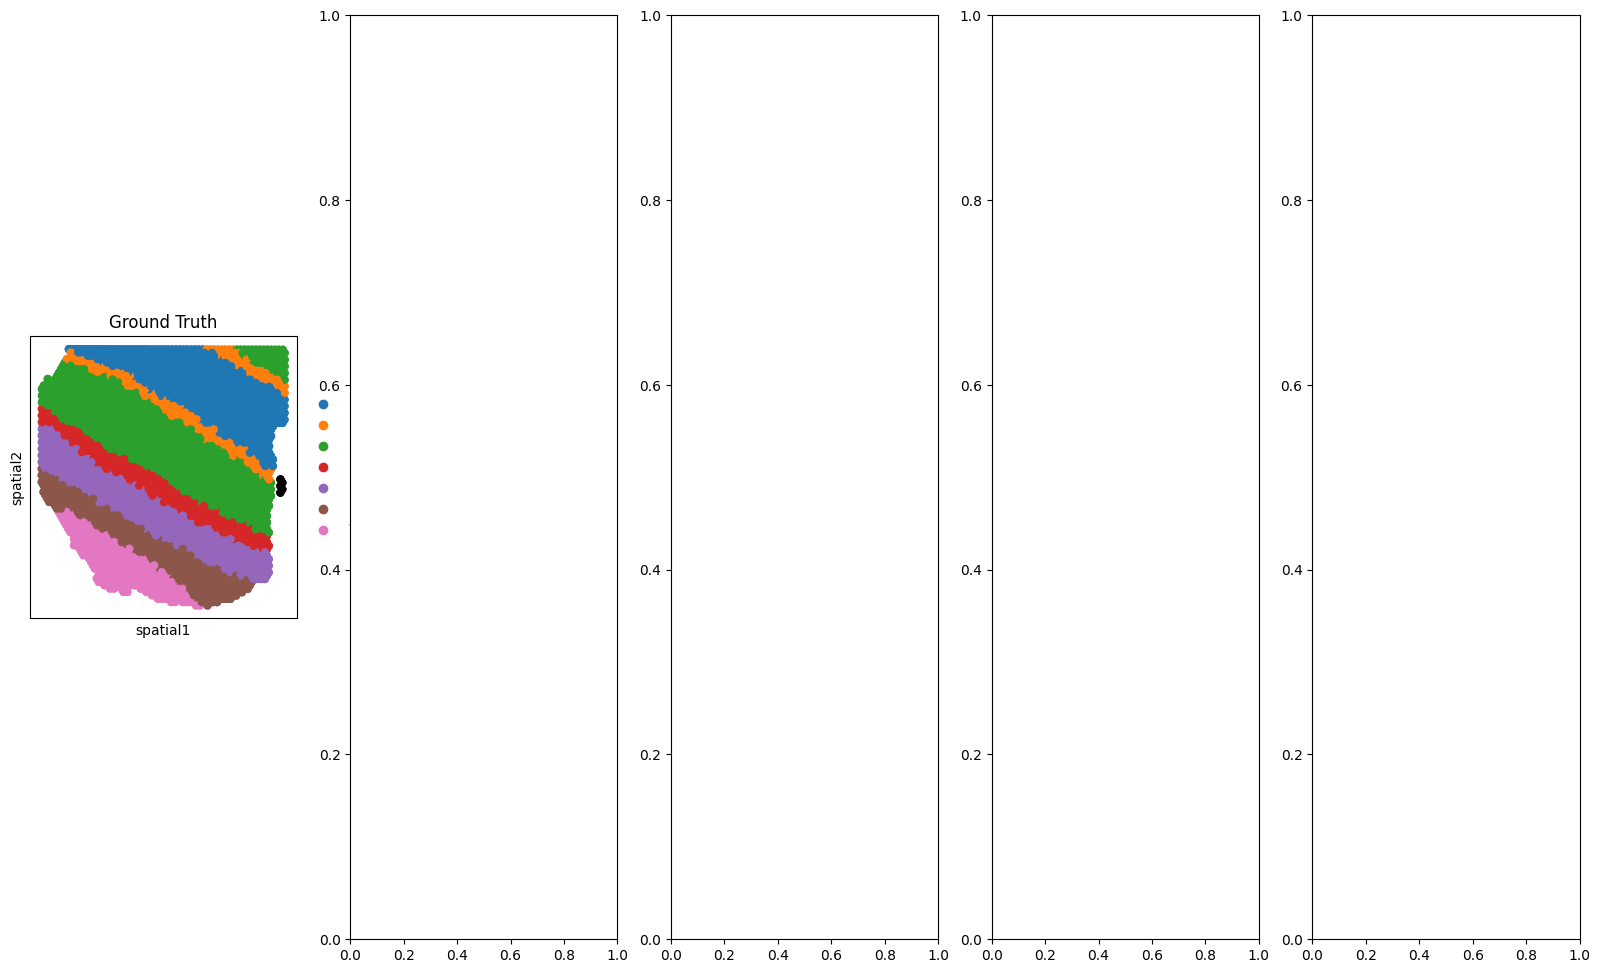

In [44]:
plot_spatial(datadir, '151672', (20,12), save=f'{figdir}/spatial_scatter')

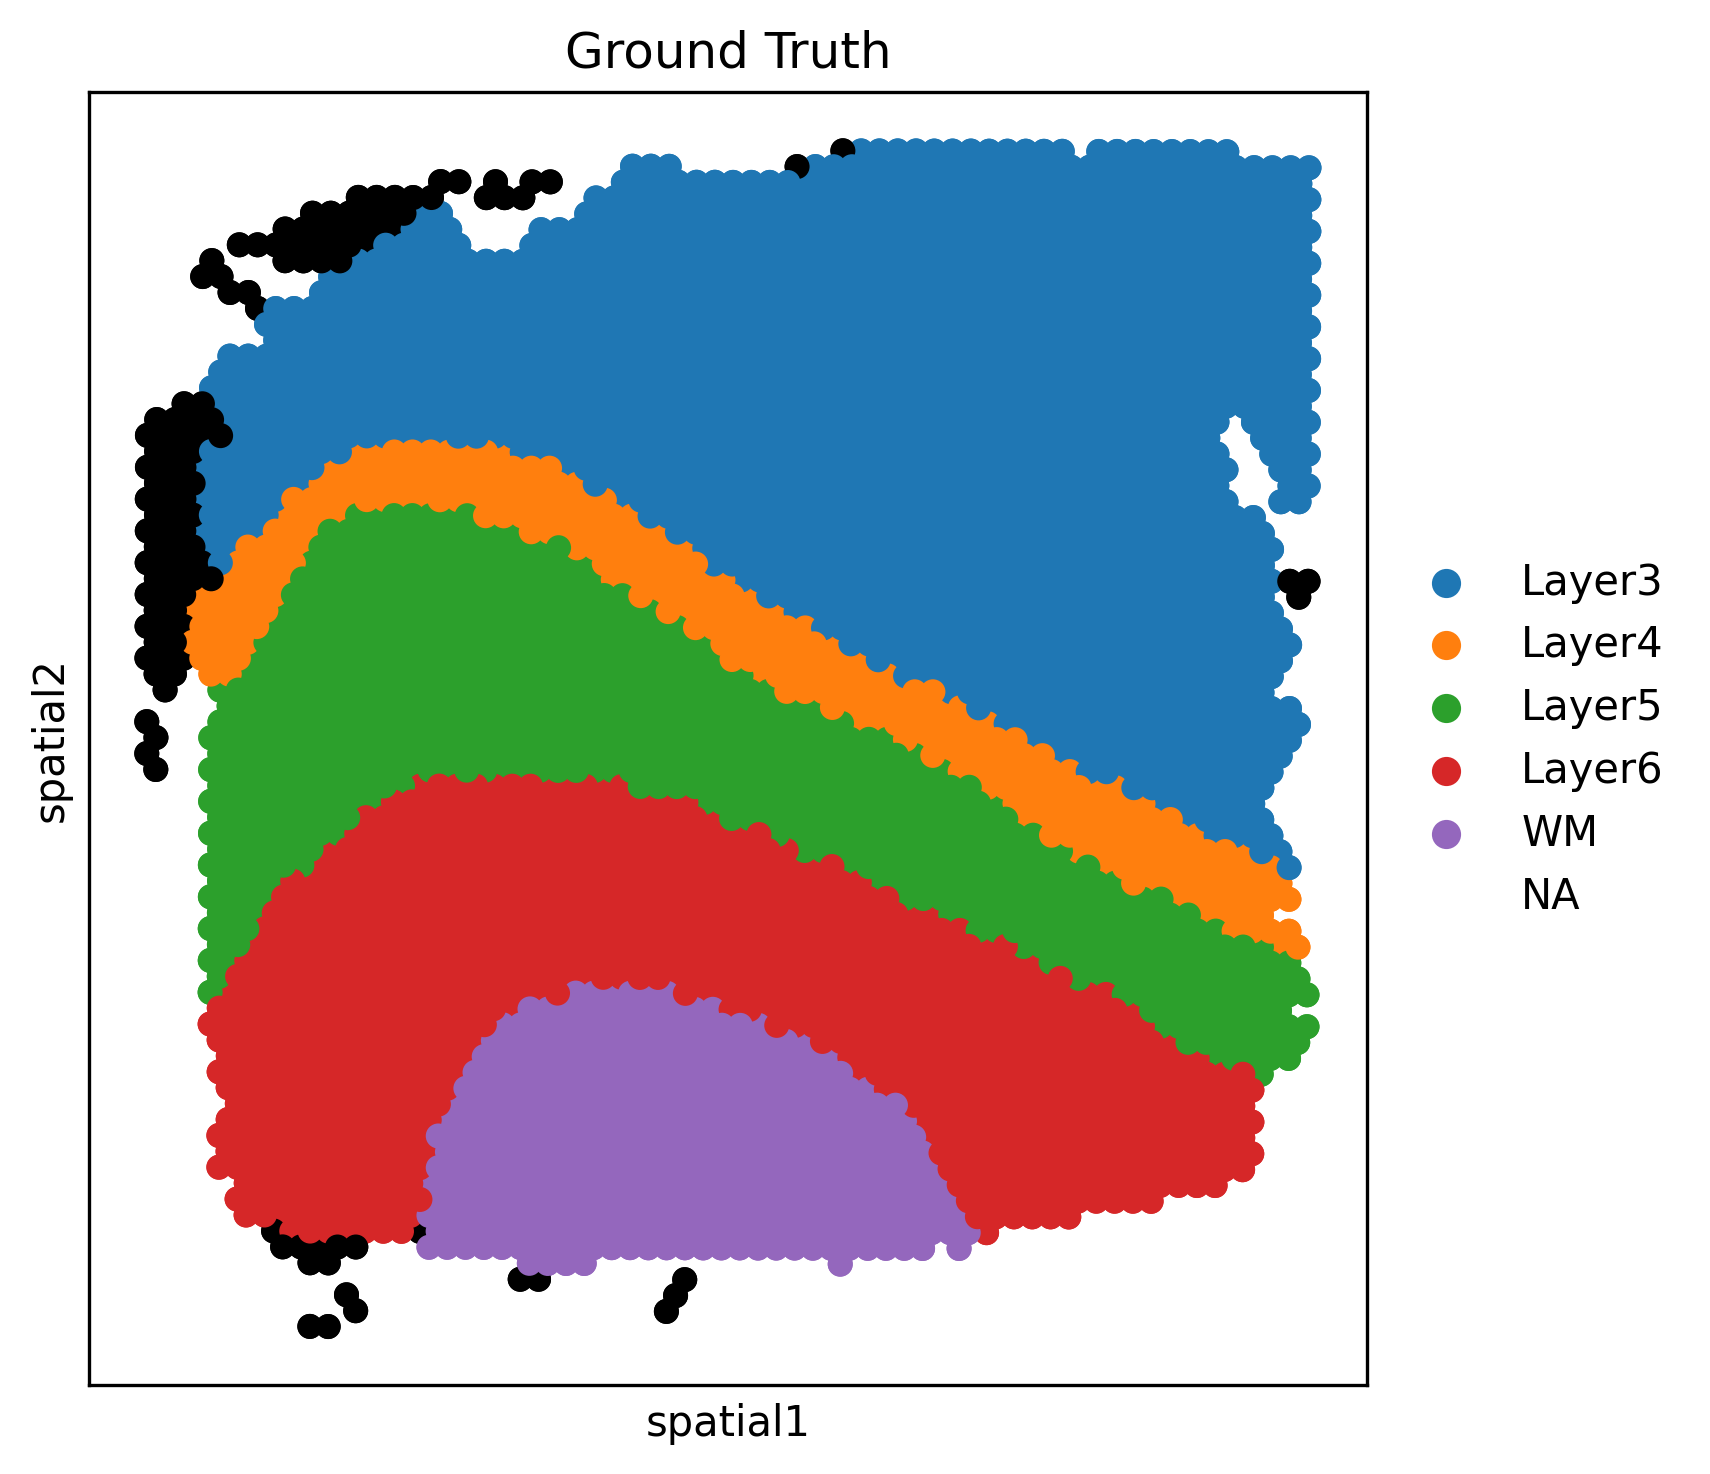

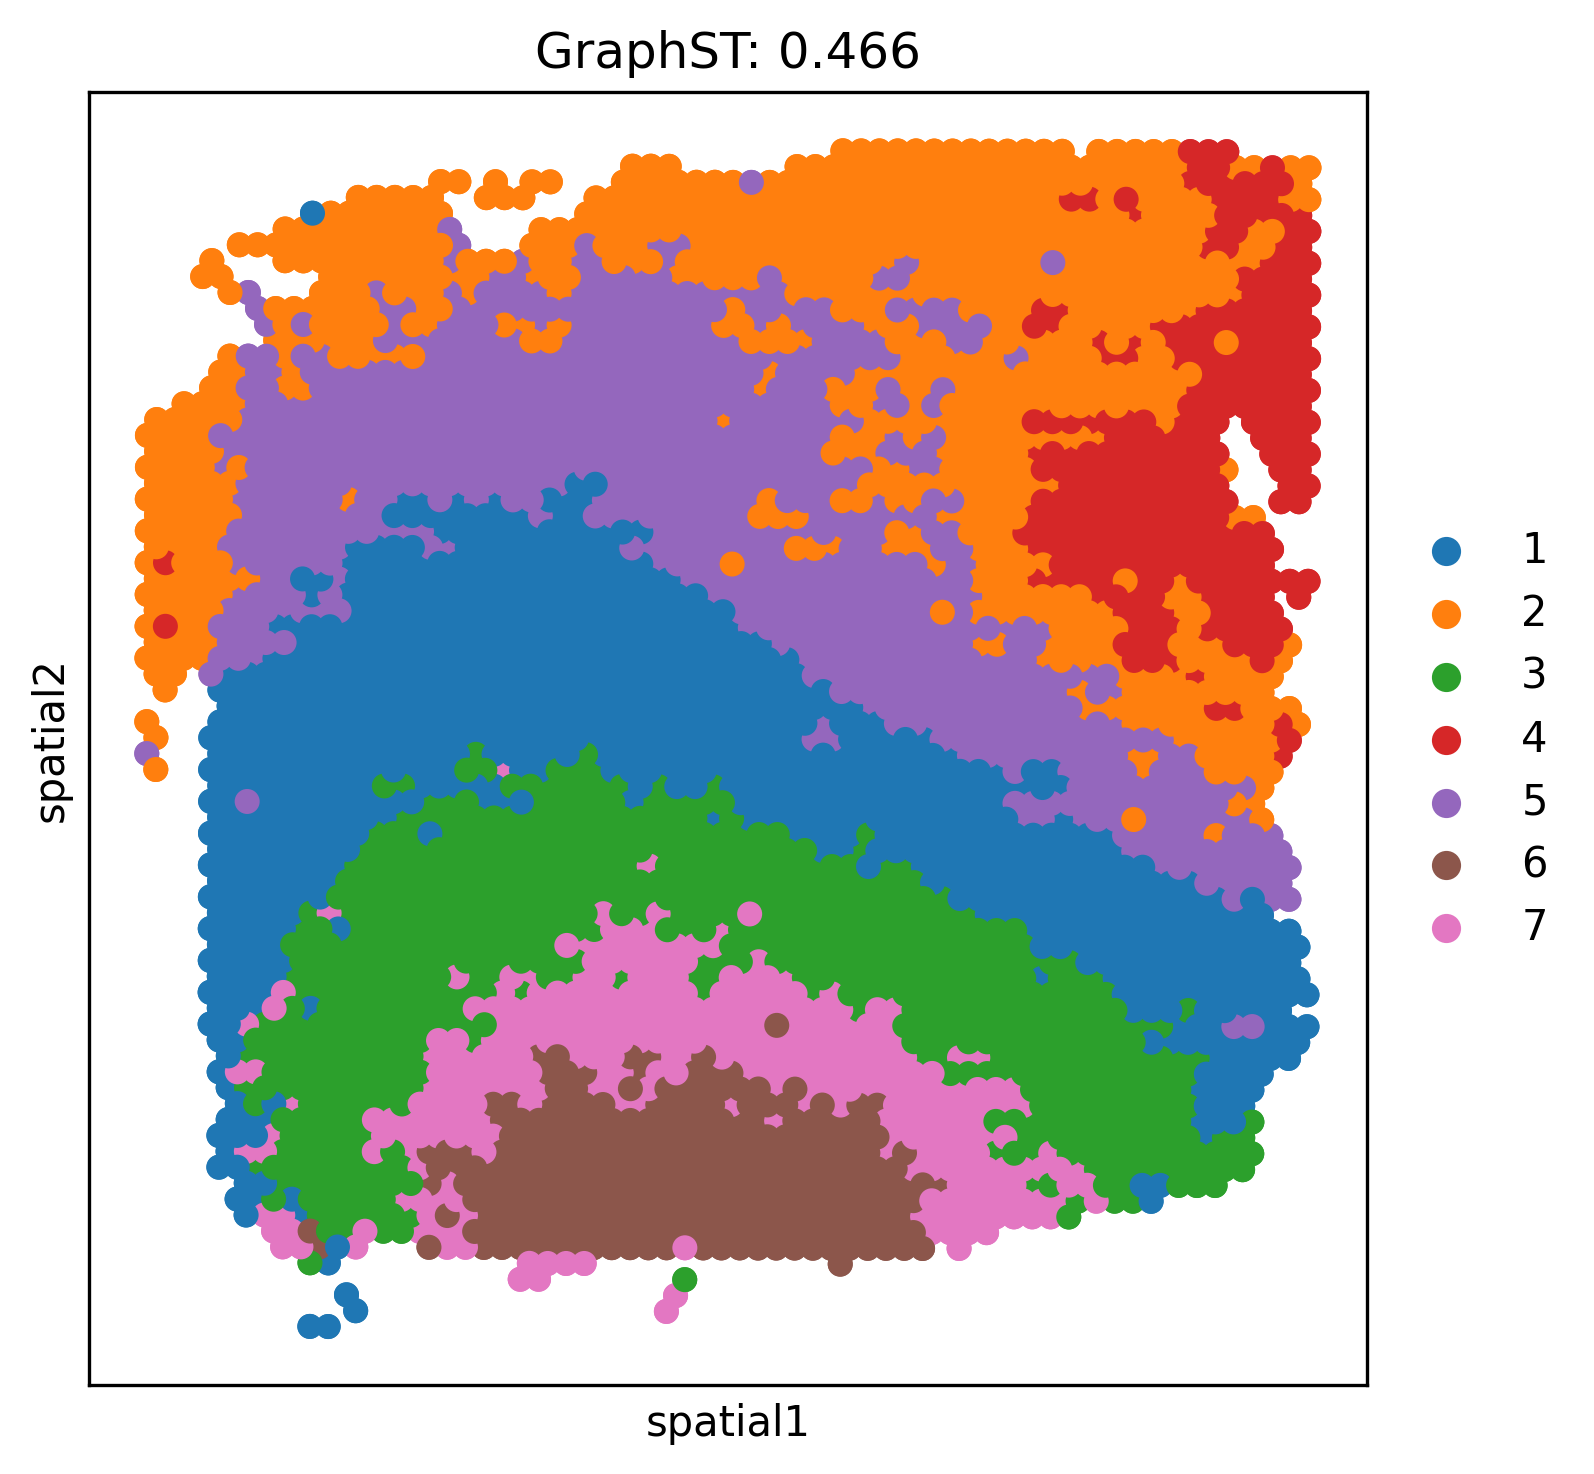

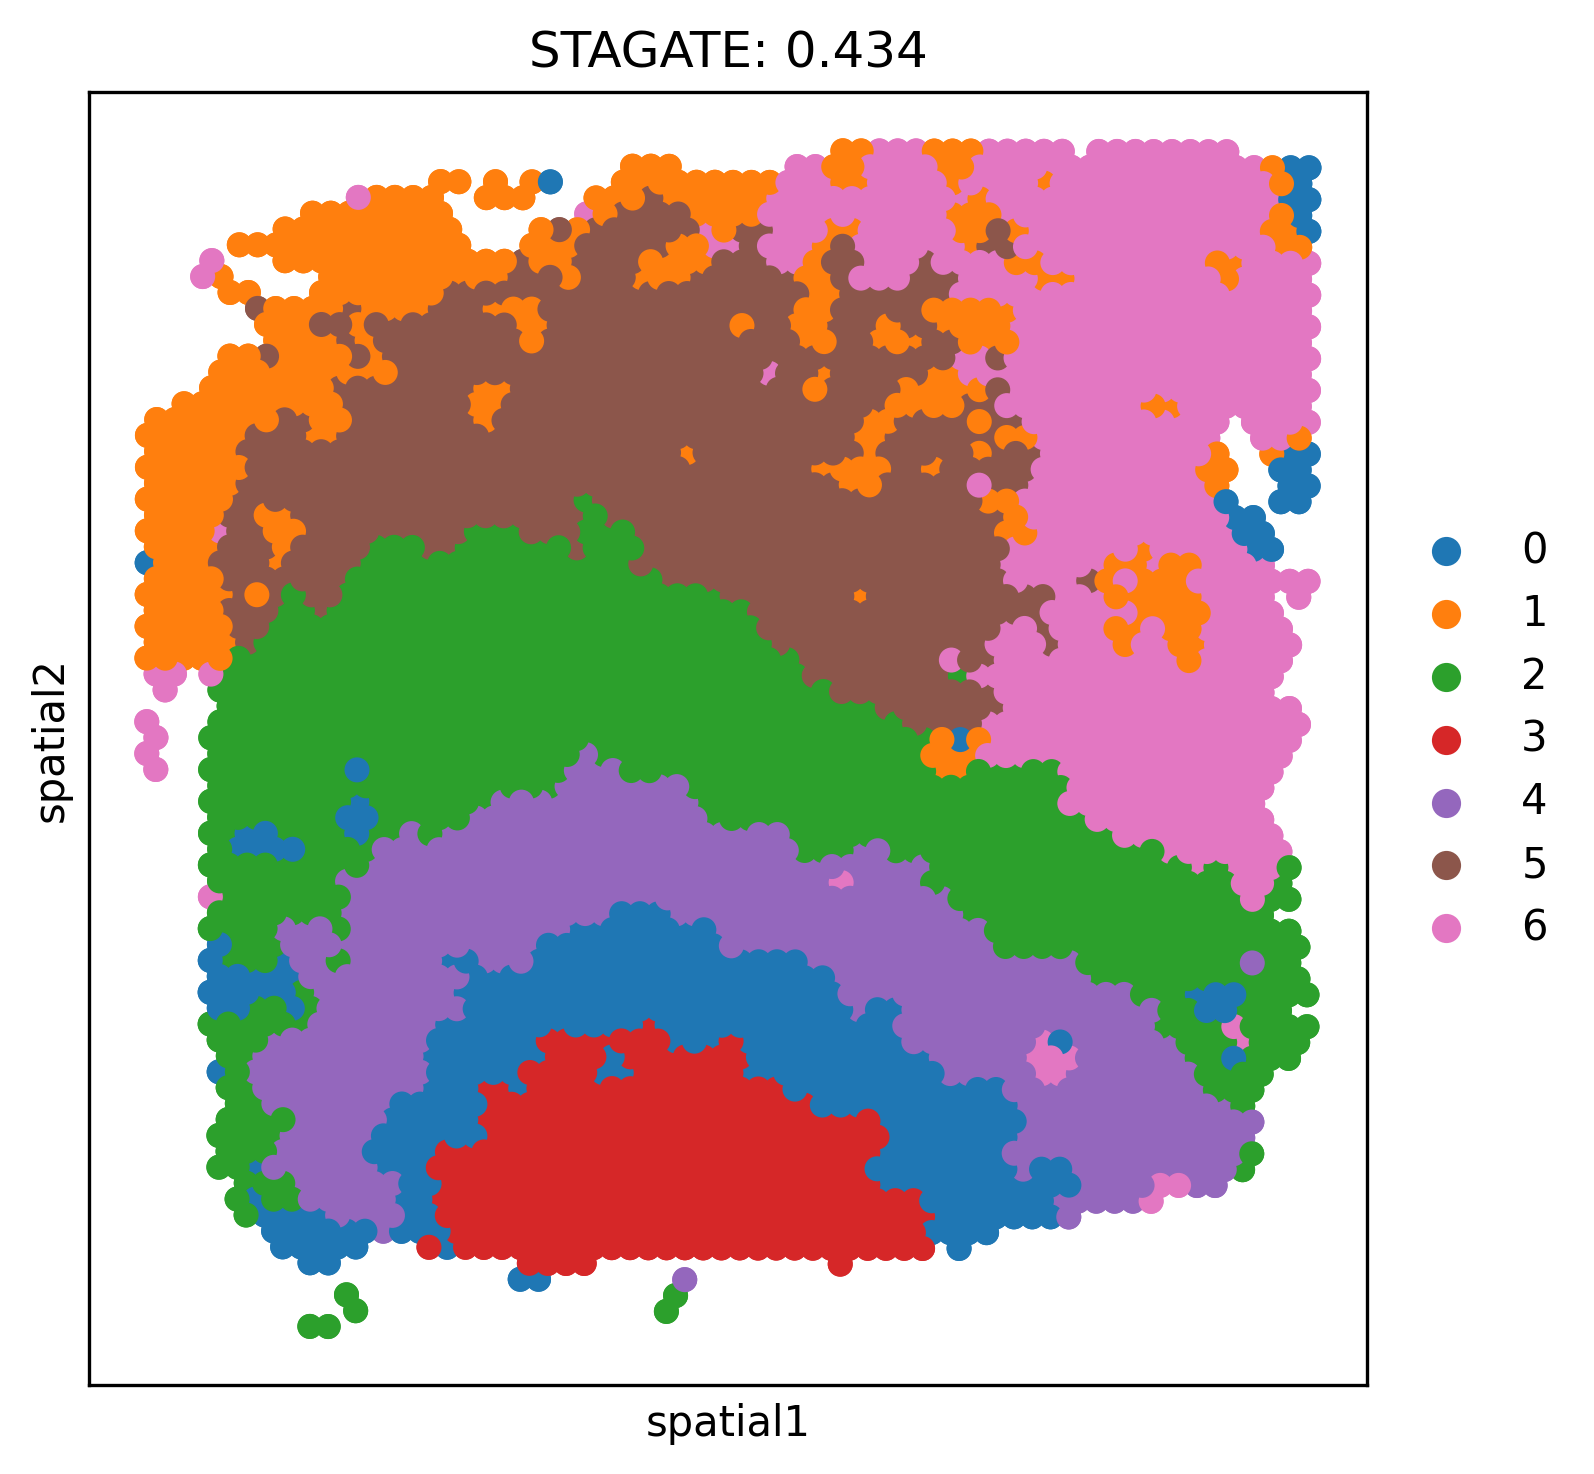

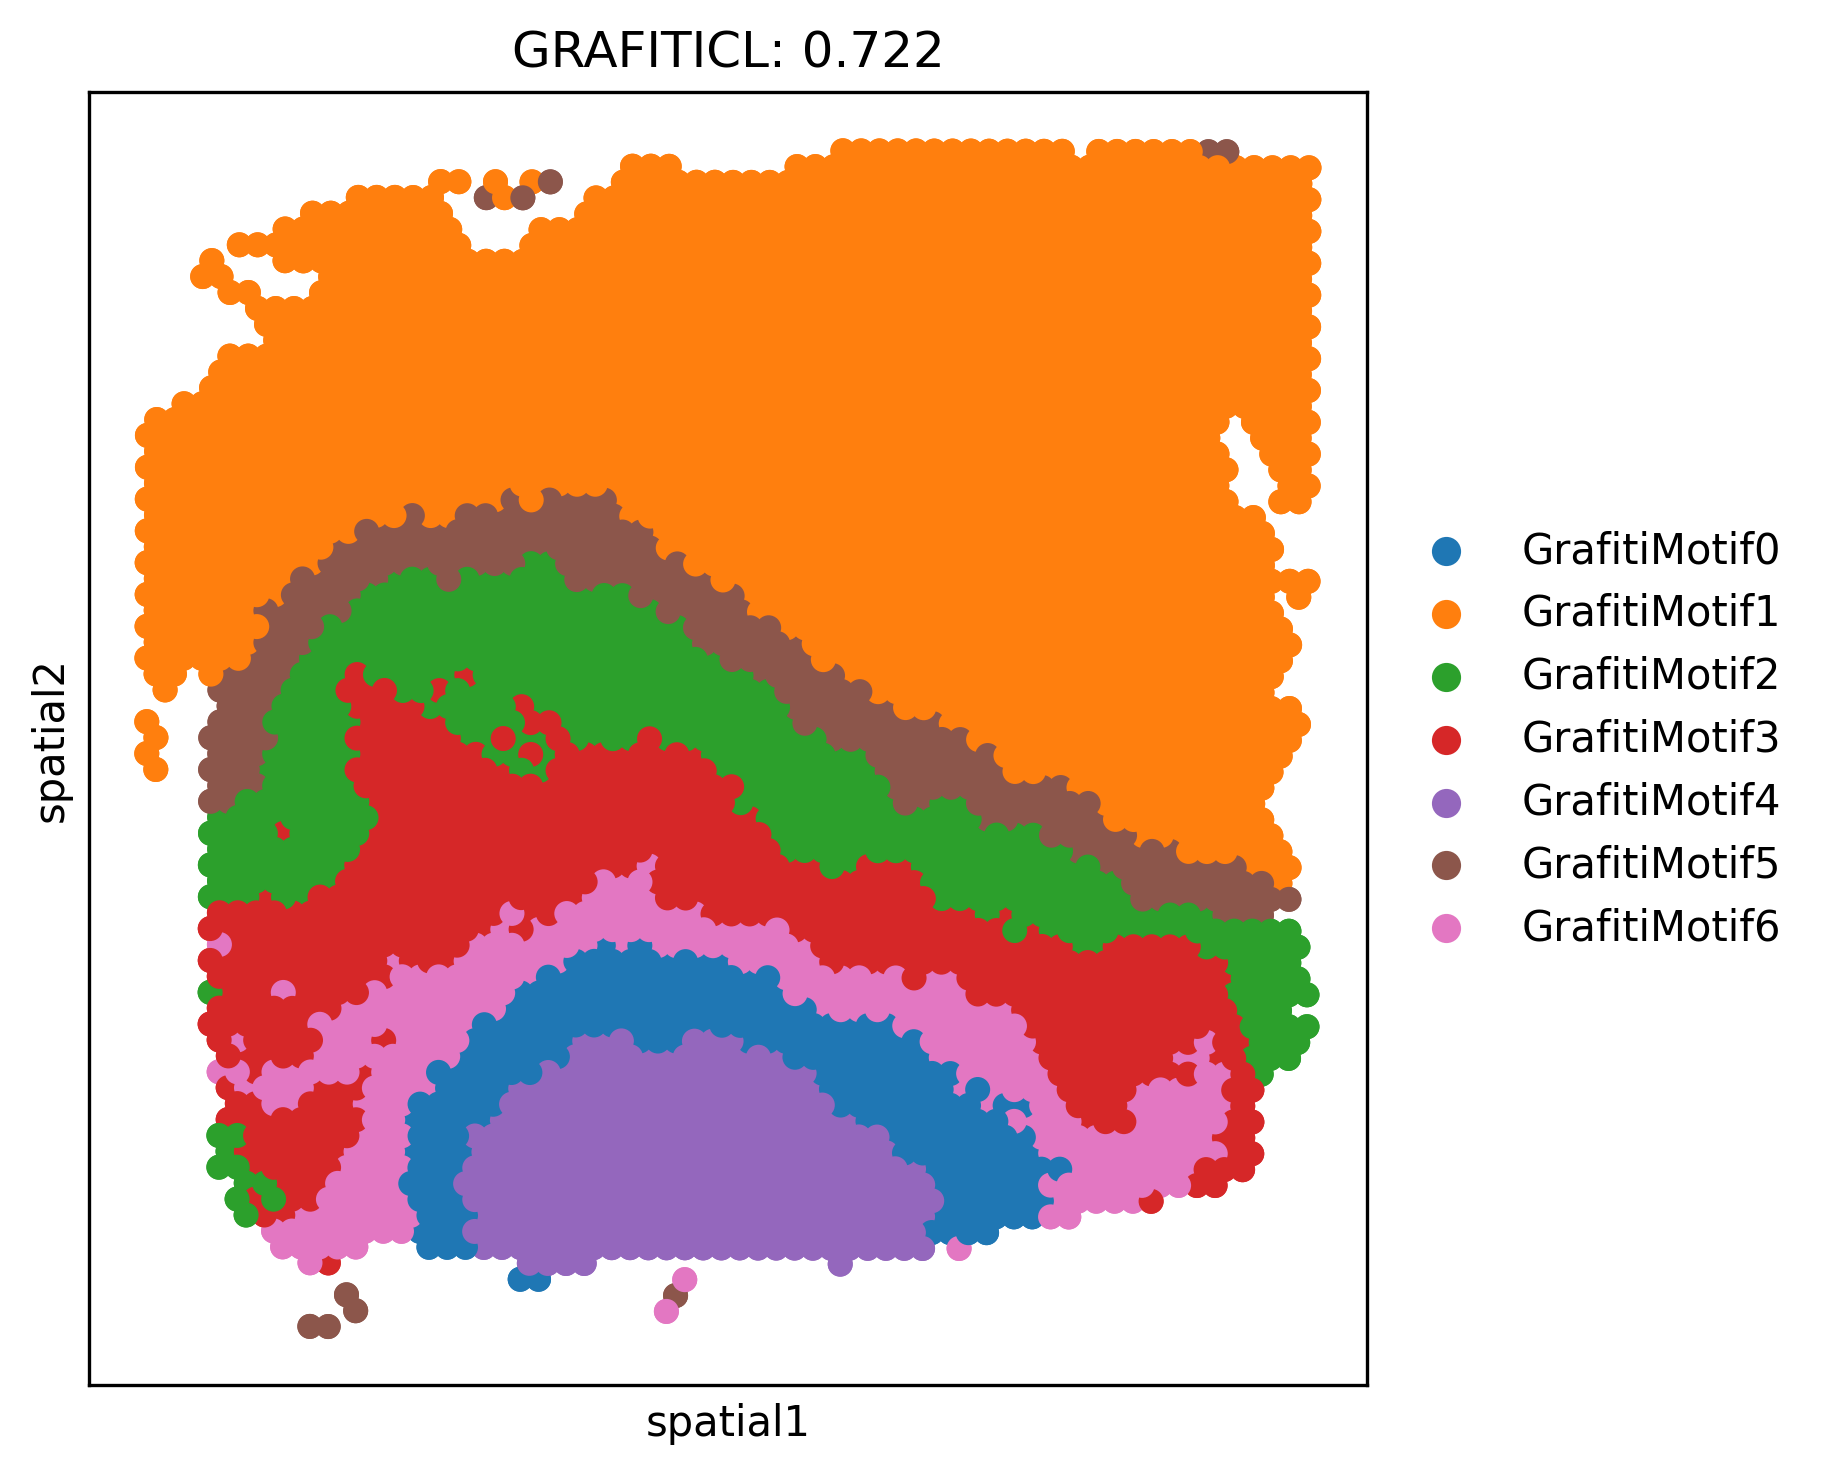

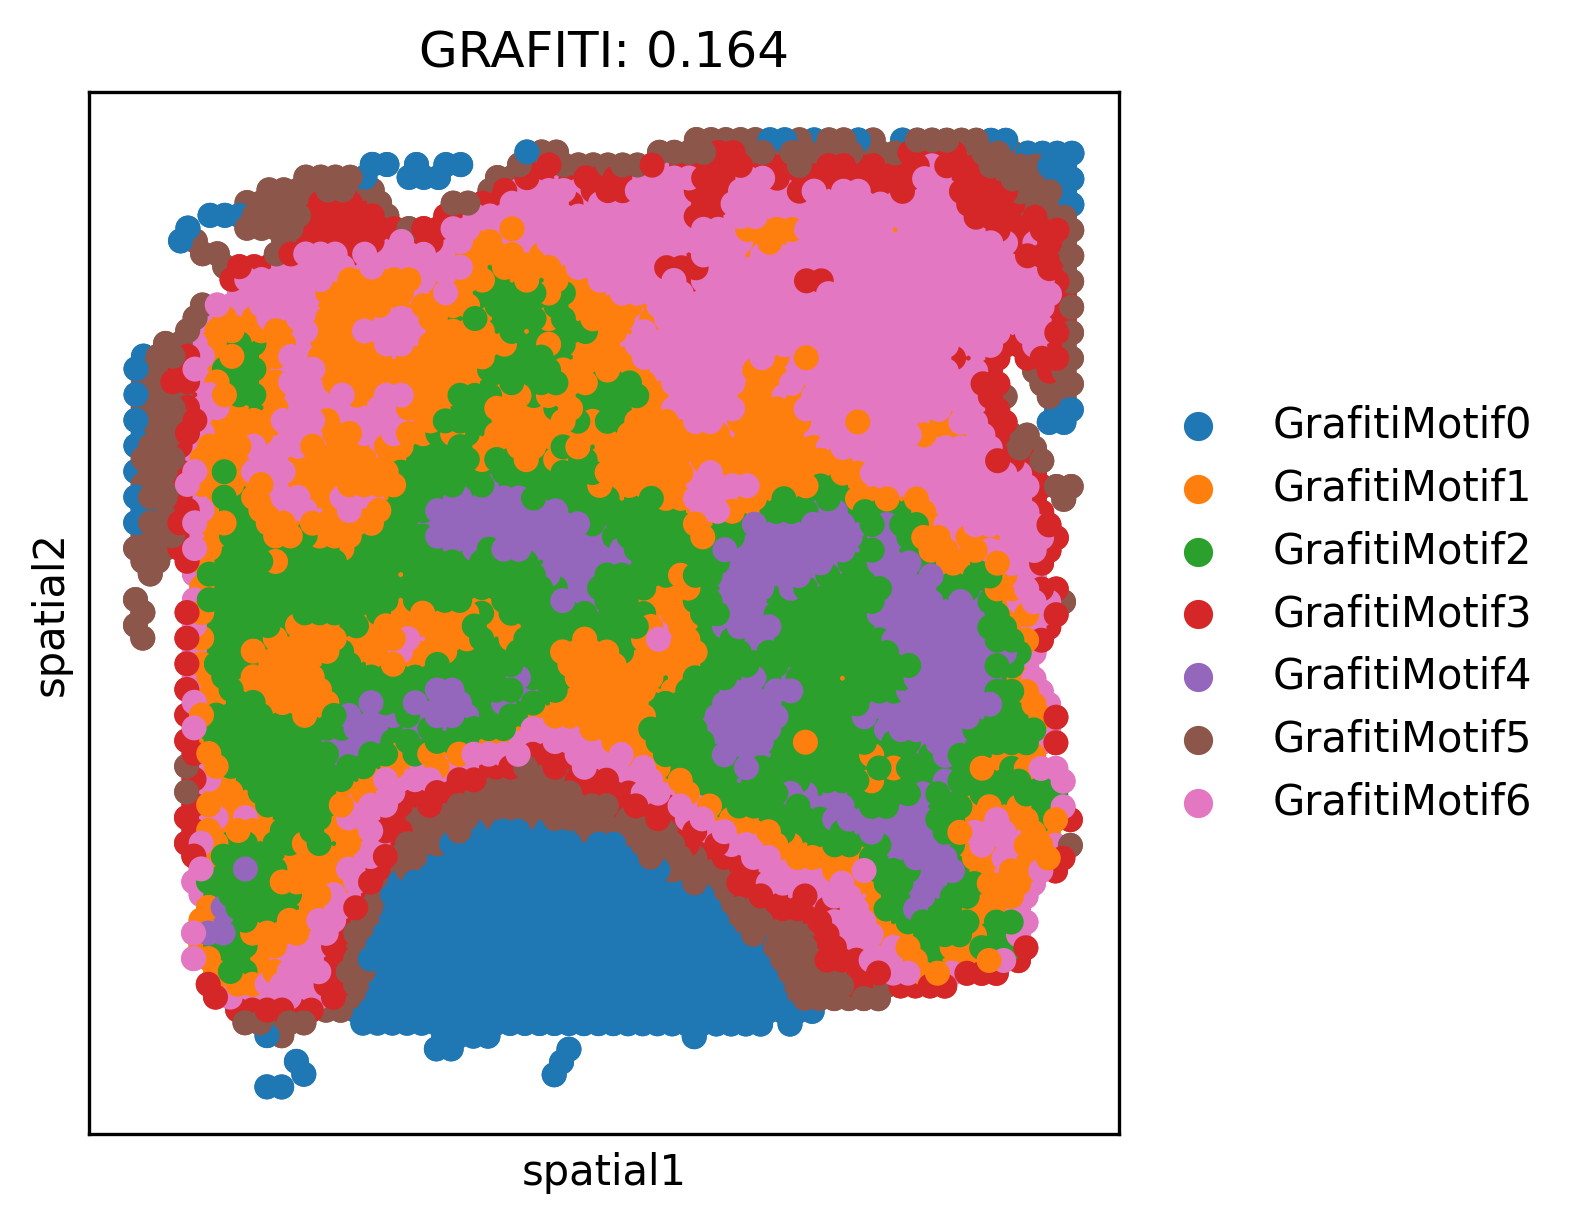

In [14]:
slice='151672'
save = f'{figdir}/{slice}_spatial_scatter'
figsize=(20,12)
adata_graphst = sc.read_h5ad(f'{datadir}/graphst/{slice}_graphst_seeded.h5ad')
adata_stagate = sc.read_h5ad(f'{datadir}/stagate/{slice}_stagate_seeded.h5ad')
adata_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{slice}_grafiti_lodcl_50_50_0.0001_1_10_1.h5ad')
adata_og_grafiti = sc.read_h5ad(f'{datadir}/grafiti/{slice}_grafiti.h5ad')

adata_stagate.obs['mclust'] = pd.Series(adata_stagate.obs['mclust']).astype('category')
    
sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color='Region', shape=None, size=100, dpi=300, save=f'{save}_gt.pdf')
sq.pl.spatial_scatter(adata_graphst, title = 'GraphST: %.3f'%(graphst[slice]), color ='mclust', shape=None, size=100, dpi=300,save=f'{save}_graphst.pdf')
sq.pl.spatial_scatter(adata_stagate, title = 'STAGATE: %.3f'%(stagate[slice]), color ='mclust', shape=None, size=100, dpi=300,save=f'{save}_stagate.pdf')
sq.pl.spatial_scatter(adata_grafiti, title = 'GRAFITICL: %.3f'%(grafiti[slice]), color ='grafiti_motif', shape=None, size=100, dpi=300,save=f'{save}_grafiti.pdf')
sq.pl.spatial_scatter(adata_og_grafiti, title = 'GRAFITI: %.3f'%(og_grafiti[slice]), color ='grafiti_motif', shape=None, size=100, dpi=300,save=f'{save}_og_grafiti.pdf')
plt.tight_layout() 
#if save != None:
# fig.savefig(save, dpi=300, bbox_inches='tight')
plt.show()

In [69]:
distribution_v2 = read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v2_distribution_s.pkl')
distribution_v3 = read_pickle(f'{datadir}/grafiti/ari_grafiti_cl_v3_distribution_s.pkl')

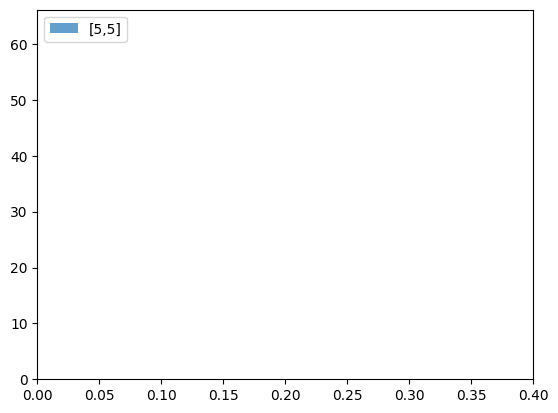

In [70]:
plt.hist(distribution_v2['151673'], label="[5,5]", alpha=.7, bins=100)
#plt.hist(distribution_v3['151673'], label="[10,1]", alpha=.7, bins=100)
plt.xlim(0,0.4)
plt.legend()
plt.show()

In [120]:
distribution_v2['151673']

[0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.3432671842347118,
 0.34319480121706863,
 0.34319480121706863,
 0.34319480121706863,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.34319480121706863,
 0.3432671842347118,
 0.34319480121706863,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.34293380588830286,
 0.34319480121706863,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.3432671842347118,
 0.34293380588830286,
 0.34293380588830286,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.3432671842347118,
 0.3432671842347118,
 0.34319480121706863,
 0.34326718423471

In [189]:
import numpy as np
xy = np.vstack([[1,2,3],[4,5,6]]).shape

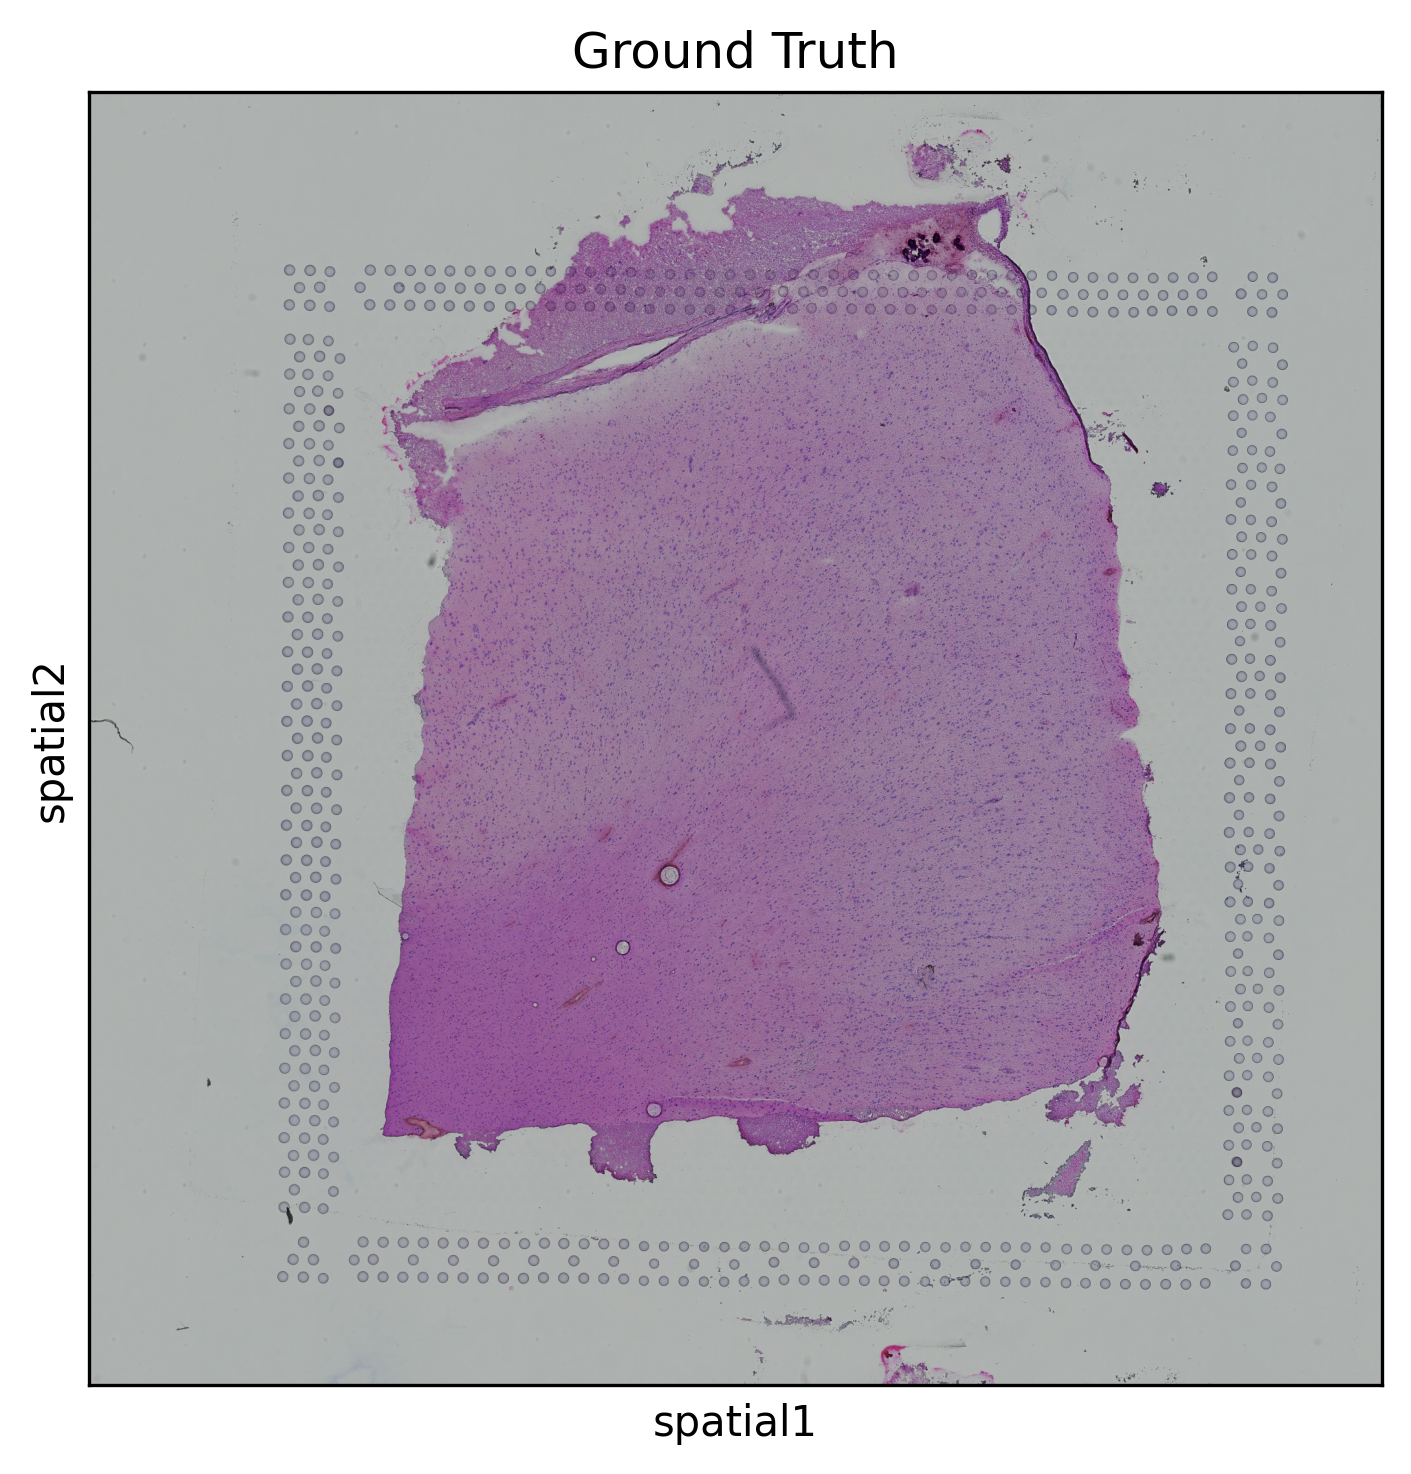

In [94]:
adata_graphst = sc.read_h5ad(f'{datadir}/graphst/151673_graphst_seeded.h5ad')
sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color=None, shape='hex', img=True, size=5, dpi=300, save=f'{figdir}/he_spatial.svg')

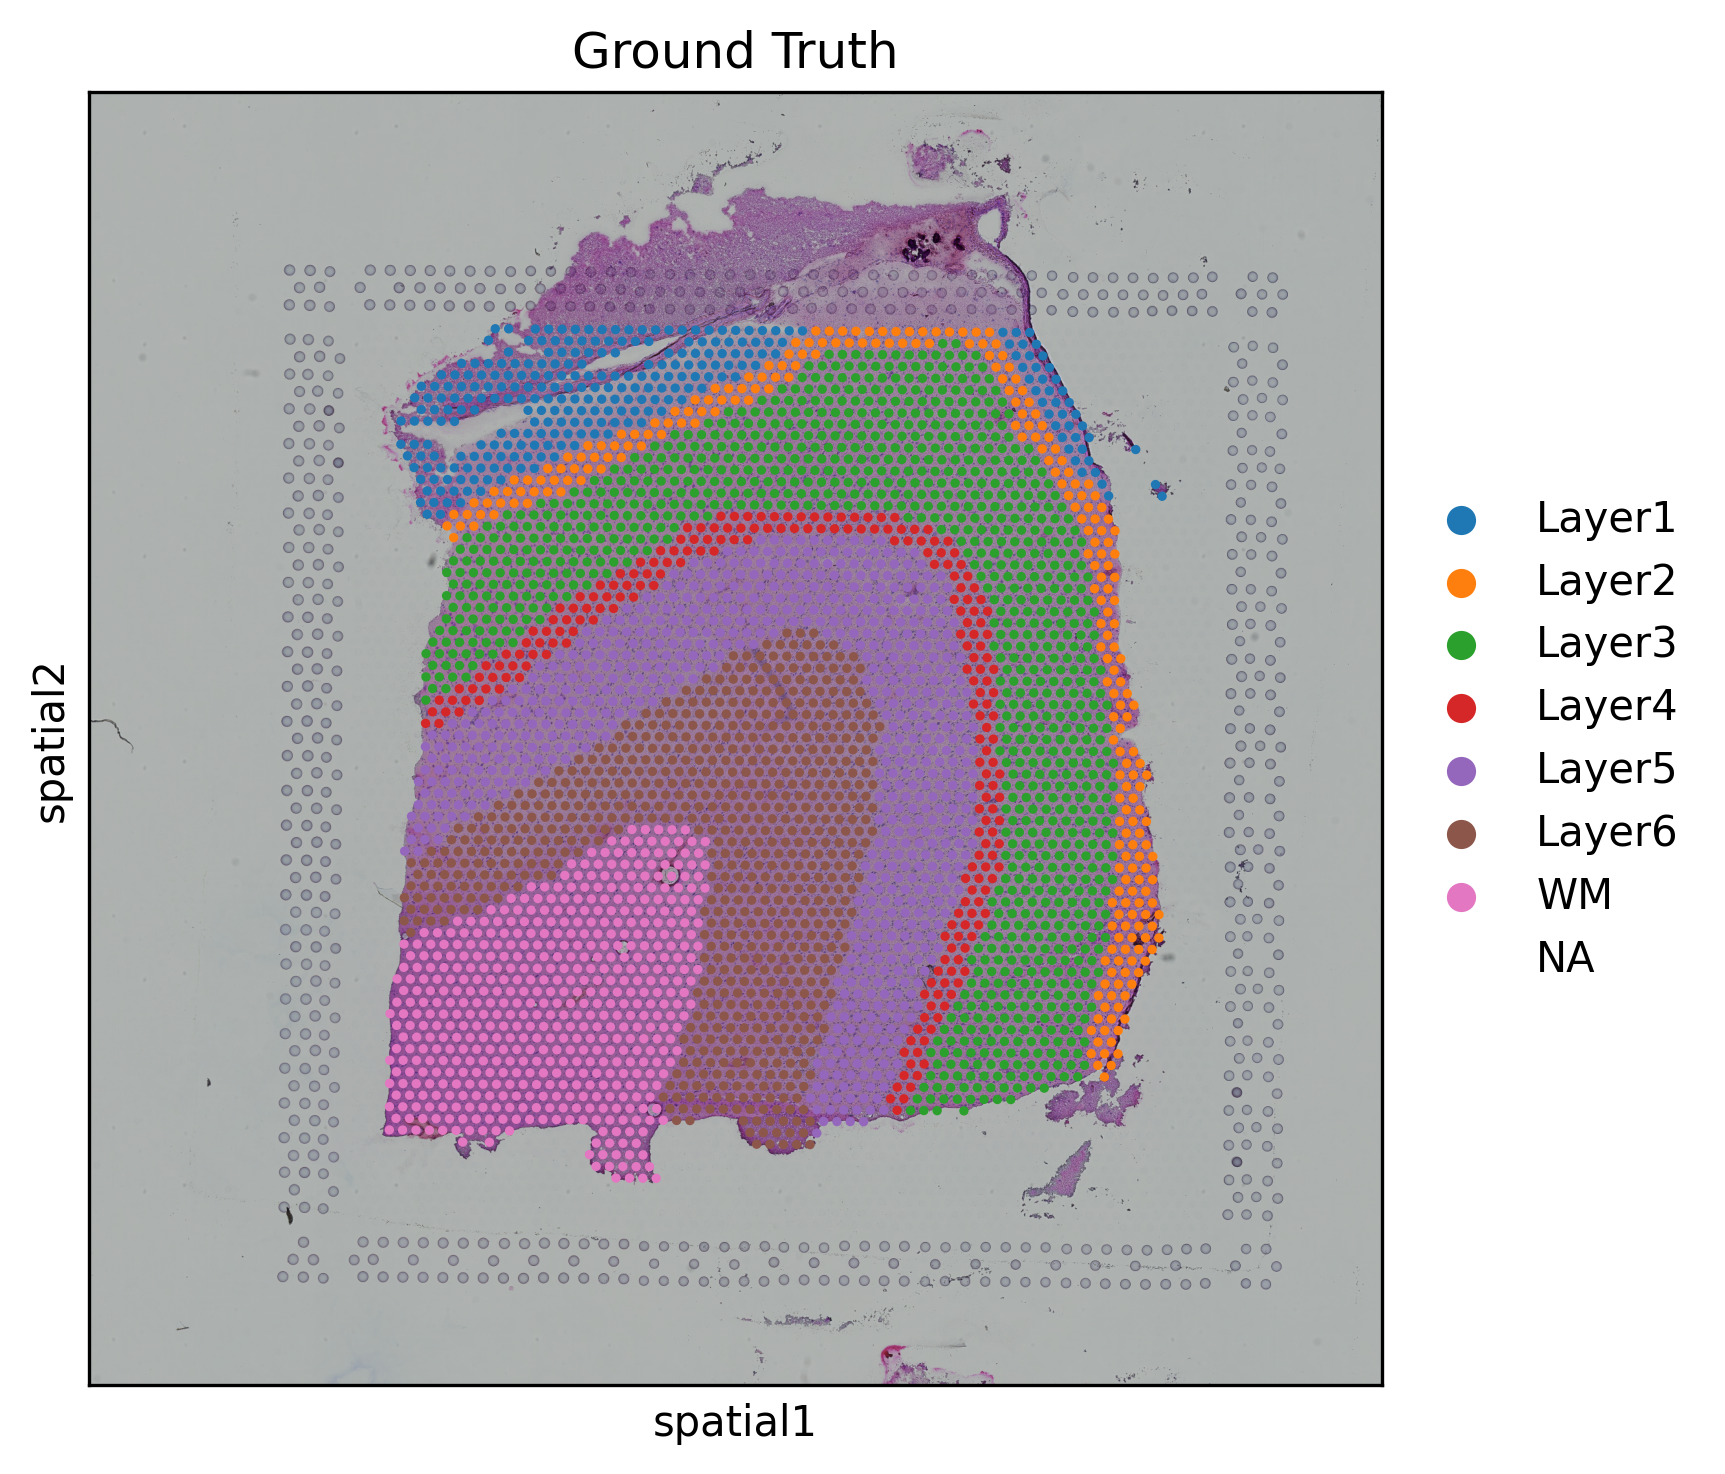

In [93]:
sq.pl.spatial_scatter(adata_graphst, title = 'Ground Truth', color='Region', shape='circle', size=1, dpi=300, save=f'{figdir}/ground_truth_spatial.svg')